In [59]:
# Initialize Otter
import otter
grader = otter.Notebook("lab01_personal_network_survey.ipynb")

In [60]:
!pip install --upgrade pandoc

In [61]:
from IPython.core.display import HTML
from datascience import *
from scipy.stats import chi2_contingency

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Lab 1: Personal Network Surveys

In this lab, we will analyze some data from the [General Social Survey](http://gss.norc.org/) (GSS).
The GSS is the survey that was the basis of the debate over whether or not Americans are becoming more socially isolated, which we discussed in class.

In [62]:
import os
os.getcwd()

'/home/jovyan/demog180-fa2024/labs/lab01'

The file `GSS.csv` has an extract from the GSS which we will analyze today.

Here is the [codebook](http://gss.norc.org/documents/codebook/GSS_Codebook.pdf) for the entire GSS. Of course, the GSS is huge, so you will have to search through for the variable names included in this extract. (Don't do this by hand -- use your pdf viewer's search function.)

Read the GSS extract into a Table called `gss_data`.

In [63]:
gss_data = Table.read_table('GSS.csv')


Let's first take a look at its contents:

In [64]:
gss_data

year,id,marital,age,numgiven,sex1,sex2,sex3,sex4,sex5,spouse1,spouse2,spouse3,spouse4,spouse5,age1,age2,age3,age4,age5
1972,1,5,23,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,2,1,70,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,3,1,48,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,4,1,27,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,5,1,61,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,6,5,26,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,7,3,28,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,8,5,27,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,9,5,21,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,10,1,30,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1


## Question 1:
How many rows and how many columns does `gss_data` have? 

*Hint: the `Table` object has two attributes, `num_columns` and `num_rows`.*

In [65]:
gss_number_of_rows = gss_data.num_rows
gss_number_of_cols = gss_data.num_columns

print("num rows: ", gss_number_of_rows)
print("num cols: ", gss_number_of_cols)

num rows:  59599
num cols:  20


In [66]:
grader.check("q1")

q1 results: All test cases passed!

## Question 2:
What range of years is covered by this dataset? Answer this by finding the largest and smallest year. 

_Hint: You can use the functions max and min that we introduced back in Lab 0_

In [67]:
largest_year = max(gss_data.column("year"))
smallest_year = min(gss_data.column("year"))

print("earliest year: ", smallest_year)
print("latest year: ", largest_year)

earliest year:  1972
latest year:  2014


In [68]:
grader.check("q2")

q2 results: All test cases passed!

In the GSS, we are interested in one question that measures social networks, namely, Question 333: *From time to time, most people discuss important matters with other people. Looking back over the last six months - who are the people with whom
you discussed matters important to you?* (GSS Codebook, p. 572). 

 It turns out that this question was only asked of the survey respondents in 1985 and 2004. In order to continue with our analysis, we will pick out only the rows of the dataset that correspond to the years we are interested in.

## Question 3:
Make two new datasets: `gss_1985` and `gss_2004` which have only the responses from 1985 and 2004, respectively.

*Hint: use functions `Table.where` and `are.equal_to(...)`*

In [69]:
gss_1985 = gss_data.where("year", are.equal_to(1985))
gss_2004 = gss_data.where("year", are.equal_to(2004))

In [70]:
grader.check("q3")

q3 results: All test cases passed!

## Question 4: 
How many responses are there from 1985, and how many from 2004? 

In [71]:
responses_from_1985 = np.count_nonzero(gss_1985.column("age"))
responses_from_2004 = np.count_nonzero(gss_2004.column("age"))

print(responses_from_1985)
print(responses_from_2004)

1534
2812


In [72]:
grader.check("q4")

q4 results: All test cases passed!

## Question 5:
We are interested in how many people survey respondents said that they discussed important matters with. That will give us information about the sizes of their personal networks.

Make a table of the values in the `numgiven` column for each year. This tables should show the possible options for `numgiven` and how often that response occurred.

*Hint: use the function `Table.group`.*

In [73]:
gss_1985_numgiven = gss_1985.group("numgiven")
gss_1985_numgiven

numgiven,count
0,136
1,228
2,235
3,321
4,233
5,294
6,84
9,3


In [74]:
gss_2004_numgiven = gss_2004.group("numgiven")
gss_2004_numgiven

numgiven,count
-1,1340
0,356
1,281
2,263
3,232
4,128
5,96
6,70
9,46


In [75]:
grader.check("q5")

q5 results: All test cases passed!

Your table for 2004 should show that quite a few respondents have -1 as the value of `numgiven`. These respondents actually did not answer the important matters question. Their `numgiven` variable is coded as -1 (*not applicable*), according to the GSS coding scheme. There are also respondents who were asked the important matters question but did not respond. Their `numgiven` variable is coded as 9 (*No answer*). 

 For our analysis, we need to drop those respondents.

## Question 6:
Narrow the 2004 dataset down so that it does not have the respondents who have -1 values for `numgiven`

_Hint: You can use the `are.above` function_

In [76]:
gss_2004_interviewed = gss_2004.where("numgiven", are.above(-1))

In [77]:
grader.check("q6")

q6 results: All test cases passed!

## Question 7:
Narrow both datasets down so that they only have respondents who were asked the important matters question  and who provided answers to that question (i.e., whose value in the `numgiven` column is neither -1 nor 9).

In [78]:
gss_1985.where('numgiven', are.not_equal_to(9)).where('numgiven', are.above(-1))

year,id,marital,age,numgiven,sex1,sex2,sex3,sex4,sex5,spouse1,spouse2,spouse3,spouse4,spouse5,age1,age2,age3,age4,age5
1985,1,1,33,6,1,2,1,1,2,2,1,2,2,2,32,29,32,35,29
1985,2,1,49,6,2,1,1,2,1,1,2,2,2,2,42,44,45,40,50
1985,3,5,23,5,2,2,2,2,2,2,2,2,2,2,25,24,46,21,35
1985,4,5,26,5,2,1,1,1,2,2,2,2,2,2,26,27,28,27,25
1985,5,5,24,5,2,2,1,1,1,2,2,2,2,2,44,25,20,19,12
1985,6,5,45,4,1,1,1,2,0,2,2,2,2,0,40,35,44,35,-1
1985,7,5,44,6,2,2,2,2,1,2,2,2,2,2,33,43,41,40,37
1985,8,5,56,5,2,1,2,1,1,2,2,2,2,2,40,50,40,50,65
1985,9,1,85,2,2,1,0,0,0,2,1,0,0,0,45,84,-1,-1,-1
1985,10,5,65,2,2,9,0,0,0,2,2,0,0,0,65,65,-1,-1,-1


In [79]:
gss_1985.where('numgiven', are.not_equal_to(9))
# gss_2004_interviewed.where('numgiven', are.not_equal_to(9))

year,id,marital,age,numgiven,sex1,sex2,sex3,sex4,sex5,spouse1,spouse2,spouse3,spouse4,spouse5,age1,age2,age3,age4,age5
1985,1,1,33,6,1,2,1,1,2,2,1,2,2,2,32,29,32,35,29
1985,2,1,49,6,2,1,1,2,1,1,2,2,2,2,42,44,45,40,50
1985,3,5,23,5,2,2,2,2,2,2,2,2,2,2,25,24,46,21,35
1985,4,5,26,5,2,1,1,1,2,2,2,2,2,2,26,27,28,27,25
1985,5,5,24,5,2,2,1,1,1,2,2,2,2,2,44,25,20,19,12
1985,6,5,45,4,1,1,1,2,0,2,2,2,2,0,40,35,44,35,-1
1985,7,5,44,6,2,2,2,2,1,2,2,2,2,2,33,43,41,40,37
1985,8,5,56,5,2,1,2,1,1,2,2,2,2,2,40,50,40,50,65
1985,9,1,85,2,2,1,0,0,0,2,1,0,0,0,45,84,-1,-1,-1
1985,10,5,65,2,2,9,0,0,0,2,2,0,0,0,65,65,-1,-1,-1


In [80]:
gss_1985_responded = gss_1985.where('numgiven', are.not_equal_to(9)).where('numgiven', are.above(-1))
gss_2004_responded = gss_2004.where('numgiven', are.not_equal_to(9)).where('numgiven', are.above(-1))

In [81]:
grader.check("q7")

q7 results: All test cases passed!

Now we have the set of respondents we will study in more detail: those who responded to the 'important matters' question.

**For the problems below, please use `gss_1985_responded` and `gss_2004_responded`.**

Many analysts have focused on how many survey respondents report that they don't discuss important matters with anyone.  They interpret the fraction of respondents who don't report discussing important matters with anyone as an indicator for the amount of social isolation. (These respondents who report not discussing important matters with anyone have `numgiven` equal to 0.)

<!-- BEGIN QUESTION -->

## Question 8:
Do you think this is a good way to try to quantify social isolation? Name one way this could be a good measure of social isolation, and one way this could be a bad measure of social isolation. Please be specific.

_To me, this does not seem like the best way to quantify social isolation. While this metric may tell a good story of **how close** someone is with their network (as discussing important matters could indicate a close relation), it does not necessarily measure how many people someone has in their network. One person could be highly socially integrated, having a large social network with many different circles, but not discuss important matters with anyone. On the other hand, someone could have one person they discuss important matters with, but speak to nobody else at any point and be extremely socially isolated._

<!-- END QUESTION -->

## Question 9:
For both the 1985 and 2004 datasets, create a new variable, `isolated` which has the value False if the respondent reports discussing important matters with anyone (`numgiven` not equal to 0), and True otherwise (`numgiven` equals to 0).


In [82]:
isolated_1985 = gss_1985_responded.column('numgiven') == 0
isolated_2004 = gss_2004_responded.column('numgiven') == 0

print(isolated_1985)
print(isolated_2004)

[False False False ..., False False False]
[ True  True False ..., False False  True]


In [83]:
grader.check("q9")

q9 results: All test cases passed!

## Question 10:
Using the variable you just created, what proportion of respondents was socially isolated in 1985? In 2004?

*Hint: we learned how to calculate mean in Lab0*

In [84]:
proportion_isolated_1985 = sum(isolated_1985)/len(isolated_1985)
proportion_isolated_2004 = sum(isolated_2004)/len(isolated_2004)

print("Proportion isolated in 1985: ", proportion_isolated_1985)
print("Proportion isolated in 2004: ", proportion_isolated_2004)

Proportion isolated in 1985:  0.0888308295232
Proportion isolated in 2004:  0.249649368864


In [85]:
grader.check("q10")

q10 results: All test cases passed!

## Question 11: Hypothesis Testing:

We can see that the proportion of socially isolated respondents is 8.9% in 1985 and 25.0% in 2004. This seems like a substantial increase in social isolation. However, it is still possible that the difference in proportion isolated is due to randomness in the data. We need to perform some form of hypothesis testing to make sure that the difference is statistically significant.

What should the appropriate null hypothesis(H0) and alternative hypothesis(H1) be?

Because isolation is a categorical variable, we can perform a Pearson's chi-squared test.

In [86]:
# Pearson's Chi-Square Test
table = [np.array([sum(isolated_1985), sum(isolated_2004)]), 
         np.array([gss_1985_responded.num_rows, gss_2004_responded.num_rows])         ]

stat, p, dof, expected = chi2_contingency(table)
# print out test statistic and p value
print(stat, p)


97.4133235946 5.62661469187e-23


In the social sciences, the commonly used significance level in hypothesis testing is 0.05. We can see that the p value of 5.62661469187e-23 is smaller than 0.05, which means we can reject the null hypothesis. The difference between proportion socially isolated in 1985 and that in 2004 is therefore statistically significant. 

## Converting from wide to long

So far, we have only looked at the number of people survey respondents discuss important matters with. However, each respondent provided specific information on the people they discuss important matters with (let's call them 'alters'). In order to look at the characteristics of all of the alters respondents reported about, we're going to have to manipulate the dataset a bit more extensively. This manipulation is a little bit tricky, but we're going to go through how it can be done step by step.

First, let's take a look at the first few rows of the dataset again to remind ourselves of how it is structured:

In [87]:
gss_data.show(6)

year,id,marital,age,numgiven,sex1,sex2,sex3,sex4,sex5,spouse1,spouse2,spouse3,spouse4,spouse5,age1,age2,age3,age4,age5
1972,1,5,23,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,2,1,70,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,3,1,48,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,4,1,27,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,5,1,61,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1
1972,6,5,26,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1


The dataset is in *wide* format: all of the information reported by a respondent is stored in a single row:

[respondent 1 info] ... [info about respondent 1's first alter] ... [info about respondent 1's second alter] ...   
[respondent 2 info] ... [info about respondent 2's first alter] ... [info about respondent 2's second alter] ...   
...

Our goal is to reshape the dataset so that the information is in *long* format instead:

[respondent 1 info] [info about respondent 1's first alter]  
[respondent 1 info] [info about respondent 1's second alter]  
[respondent 1 info] [info about respondent 1's third alter]  
[respondent 1 info] [info about respondent 1's fourth alter]  
[respondent 1 info] [info about respondent 1's fifth alter]  
[respondent 2 info] [info about respondent 2's first alter]  
[respondent 2 info] [info about respondent 2's second alter]  
...

In order to convert the alter information from wide to long format, we're going to use two functions that have been written for you below.

Let's look at the function below and try to understand how it works.

PS. The portion highlighted in red is called a docstring. It describes what the function does and gives examples. The code following ">>>" is fully executable and the following line is what that function call should return.

In [88]:
def repeat_single_col(data, var_name, times=5):
    """Repeats a single column multiple times.
    
    Parameters
    ----------
    var_name : str
        Text that contains the name of the column to repeat.
    
    Returns
    -------
    np.array
        A single array with the contents of the column repeated five times.
    
    Examples
    --------
    >>> repeat_single_col(Table().with_columns(['respondent_age', [10]]),
                          'respondent_age')
    
    array([10, 10, 10, 10, 10])
    """
    new_col = np.tile(data.column(var_name), times)
    return new_col

The key to understanding repeat_single_col is the `np.tile` function. Look that function up and read its help page.

**Practice** Use `np.tile` to create an array that contains [1,3,5,7,1,3,5,7,1,3,5,7,1,3,5,7].

In [89]:
np.tile # You can remove the # sign and see the 'help' documentation for np.tile
practice = [1, 3, 5, 7]
practice_array = np.tile(practice, 4)
practice_array

array([1, 3, 5, 7, 1, 3, 5, 7, 1, 3, 5, 7, 1, 3, 5, 7])

**Practice** What is the difference between `np.tile` and `np.repeat`? Do they do the same thing? What happens if you pass the same arguments to `np.repeat` as to `np.tile`?

[Hint: you can use the help page to figure out what np.repeat does.]

In [90]:
#np.repeat? # You can remove the # sign and see the 'help' documentation for np.repeat
practice2 = [1, 3, 5, 7]
practice2_array = np.repeat(practice2, 4)
practice2_array

array([1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5, 5, 7, 7, 7, 7])

Now look at the next function, and try to understand how it works.

In [91]:
def wide_to_long(data, var_name, times=5):
    """Given columns of alter characteristics, stack them into one long column.
    
    Parameters
    ----------
    data : Table
        The data table containing the alter characteristics
    var_name : str
        Text that contains the variable name; columns of the dataset should
        match the pattern: [var_name][alter_number]
        For example, if var_name is 'age' then this function expects to find
        columns in the survey dataset named 
        'age1', 'age2', 'age3', 'age4', and 'age5'
    times : int
        The number of columns for each characteristic
    
    Returns
    -------
    np.array
        A single array with the contents of all of the columns stacked on top of one another.
    
    Examples
    --------
    >>> wide_to_long(Table().with_columns(['age1', [10, 15],
                                           'age2', [30, 35],
                                           'age3', [20, 15],
                                           'age4', [60, 70],
                                           'age5', [20, 25]]),
                     'age')
    
    array([10, 15, 30, 35, 20, 15, 60, 70, 20, 25])
    """
    new_col = np.concatenate([data.column(var_name + str(idx)) for idx in range(1,times+1)])
    return new_col

The key to understanding this second function is np.concatenate. Look up the help page for np.concatenate.

In [92]:
np.concatenate?

Call signature:  np.concatenate(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <built-in function concatenate>
Docstring:      
concatenate((a1, a2, ...), axis=0, out=None, dtype=None, casting="same_kind")

Join a sequence of arrays along an existing axis.

Parameters
----------
a1, a2, ... : sequence of array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int, optional
    The axis along which the arrays will be joined.  If axis is None,
    arrays are flattened before use.  Default is 0.
out : ndarray, optional
    If provided, the destination to place the result. The shape must be
    correct, matching that of what concatenate would have returned if no
    out argument were specified.
dtype : str or dtype
    If provided, the destination array will have this dtype. Cannot be
    provided together with `out`.

    .. versionadded:: 1.20.0

casting : {'no', 'equiv', 'safe', 

**Practice** Use `np.concatenate` to make a single array that has the contents of `column_one` and `column_two` concatenated together:

In [93]:
concat_table = Table().with_columns(['column_one', [1,3,5,7,9],
                                    'column_two', [2,4,6,8,10]])
concat_table

column_one,column_two
1,2
3,4
5,6
7,8
9,10


In [94]:
#to make a single array with the contents of column_one and column_two
column_one = concat_table.column('column_one') 
column_two = concat_table.column('column_two')
concat_array = np.concatenate((column_one, column_two))
concat_array

array([ 1,  3,  5,  7,  9,  2,  4,  6,  8, 10])

Now that we understand what `np.concatenate` does, let's run the wide_to_long() function on a simple table to see what it does.

In [95]:
temp_table = Table().with_columns(['age1', [10, 15],
                                   'age2', [30, 35],
                                   'age3', [20, 15],
                                   'age4', [60, 70],
                                   'age5', [20, 25]])
wide_to_long(temp_table,'age')

array([10, 15, 30, 35, 20, 15, 60, 70, 20, 25])

You can see that it links the head and end of columns.

We'll take a first try at converting `gss_1985_responded` to long format together, and then you'll do a more complete job as an exercise.

For our first step, we'll only keep the respondent's id number and the age of the alters each respondent reported about. Since there is space for 5 alters per respondent, we expect (number of respondents x 5)

Let's construct the table.

In [96]:
alter_first_try = Table().with_columns([
    'id', repeat_single_col(gss_1985_responded, 'id'),
    'alter_age', wide_to_long(gss_1985_responded, 'age')])
alter_first_try

id,alter_age
1,32
2,42
3,25
4,26
5,44
6,40
7,33
8,40
9,45
10,65


You can see that we want to use `repeat_single_col` for the column that is a respondent characteristic and that we want to use `wide_to_long` for the column that is an alter characteristic.

Let's check that the resulting Table, called `alter_first_try` makes sense.



## Question 12: 
How many rows do you think alter_first_try should have? Check the number of rows.

In [97]:
q1 = alter_first_try.num_rows
q1

7655

In [98]:
grader.check("q12")

q12 results: All test cases passed!

In [99]:
gss_1985_responded

year,id,marital,age,numgiven,sex1,sex2,sex3,sex4,sex5,spouse1,spouse2,spouse3,spouse4,spouse5,age1,age2,age3,age4,age5
1985,1,1,33,6,1,2,1,1,2,2,1,2,2,2,32,29,32,35,29
1985,2,1,49,6,2,1,1,2,1,1,2,2,2,2,42,44,45,40,50
1985,3,5,23,5,2,2,2,2,2,2,2,2,2,2,25,24,46,21,35
1985,4,5,26,5,2,1,1,1,2,2,2,2,2,2,26,27,28,27,25
1985,5,5,24,5,2,2,1,1,1,2,2,2,2,2,44,25,20,19,12
1985,6,5,45,4,1,1,1,2,0,2,2,2,2,0,40,35,44,35,-1
1985,7,5,44,6,2,2,2,2,1,2,2,2,2,2,33,43,41,40,37
1985,8,5,56,5,2,1,2,1,1,2,2,2,2,2,40,50,40,50,65
1985,9,1,85,2,2,1,0,0,0,2,1,0,0,0,45,84,-1,-1,-1
1985,10,5,65,2,2,9,0,0,0,2,2,0,0,0,65,65,-1,-1,-1


## Question 13: 
Now we will use these functions to convert the wide-format data from 1985 and 2004 into long format. This will enable us to examine whether or not there is evidence of homophily in the GSS confidant reports from those two years.

Be sure to include the following:

* respondent's age
* alter's age


In [103]:
gss_1985_long_raw = Table().with_columns([
    'respondents age', repeat_single_col(gss_1985_responded, 'age'),
    'alter_age', wide_to_long(gss_1985_responded, 'age')])
gss_2004_long_raw = Table().with_columns([
    'respondents age', repeat_single_col(gss_2004_responded, 'age'),
    'alter_age', wide_to_long(gss_2004_responded, 'age')])

gss_2004_long_raw

respondents age,alter_age
52,-1
43,-1
52,56
34,63
22,-1
26,25
74,-1
58,57
32,-1
48,50


In [111]:
grader.check("q13")

q13 results: All test cases passed!

## Question 13:
Not all respondents reported 5 alters. In cases where alter information is missing, `alter_age` is coded as -1. Furthermore, in cases where respondents did report about an alter, but they did not know or refused to give the alter's age, [the codebook](http://gss.norc.org/documents/codebook/GSS_Codebook.pdf) tells use that `alter_age` will have the value 98 or 99.

Create the Tables gss_1985_long and gss_2004_long, which start from `gss_1985_long_raw` and `gss_2004_long_raw` and filter out rows where `alter_age` equals -1, 98, or 99 so that we are left with only actual reported alters whose age was given.

*Hint: use `.where()` and `are.not_equal_to()` to perform filtering.*

In [109]:
gss_1985_long = gss_1985_long_raw.where("alter_age", are.between(0, 98))
#gss_1985_long = gss_1985_long.where(...)
#gss_1985_long = gss_1985_long.where(...)

gss_2004_long = gss_2004_long_raw.where("alter_age", are.between(0, 98))
#gss_2004_long = gss_2004_long.where(...)
#gss_2004_long = gss_2004_long.where(...)

In [110]:
grader.check("q13")

q13 results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 14:
Create a scatterplot of the respondent's age and the alter's age (make a separate plot for 1985 and for 2004).

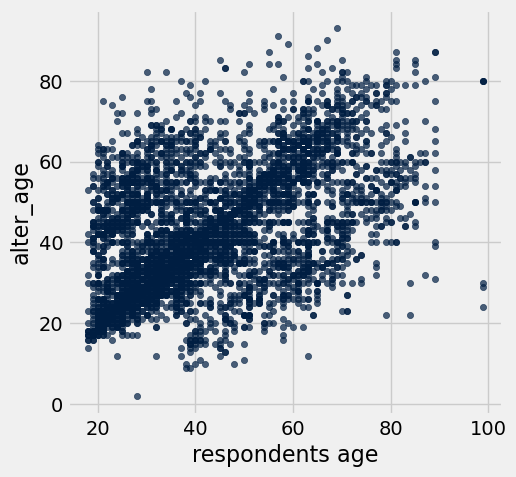

In [113]:
gss_1985_long.scatter("respondents age", "alter_age")

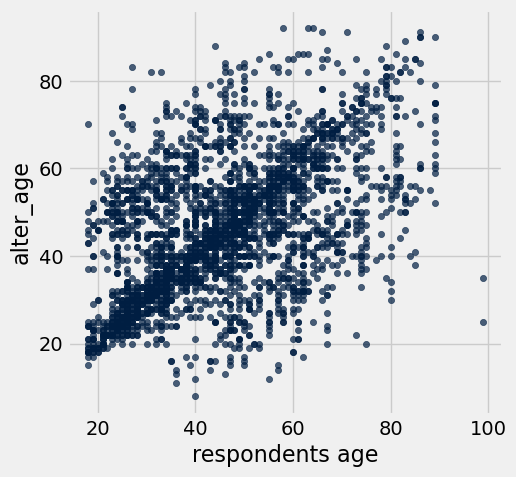

In [114]:
gss_2004_long.scatter("respondents age", "alter_age")

<!-- END QUESTION -->

## Additional Topic: Sampling Variation and Bootstrapping

Most data we collect or use is based on a "sample" of some sort. For example, the dataset we will create with your Homework 1 personal networks survey tells us something about the personal networks of Berkeley students.
But if we talked to a different set of Berkeley students, we could get a different answer. How do we know if what we observe in our sample is a good reflection of the real world? How does the variation in our sample relate to variation in the real world?

We can actually estimate the sampling variation within our data, if we assume our data is sampled randomly. (This is a stretch, of course - we won't actually take a random sample. What difference might we expect between the people in our dataset and a randomly selected set of Berkeley students?)

In order to estimate the sampling variation, we'll use an approach called resampling or the bootstrap. This is a topic we'll cover in more depth later, but this is a quick introduction.

Bootstrapping involves resampling the data. If we picture our data sample as a bag of coins, where each coin is an observation, bootstrapping is the processing of putting all drawn coins back into the bag, reaching into the bag again and randomly drawing from the sample we've already collected. Let us resample the `numgiven` column in the GSS data we used as an example:


In [115]:
resampled_survey = gss_1985_responded.select('numgiven').sample()

To see what happened here, let's look at resampled_survey:

In [116]:
resampled_survey

numgiven
3
3
3
6
3
5
3
2
5
0


`resampled_survey` is a random sample of the data from the `numgiven` values recorded in the original GSS data.
To estimate the sampling variation, we need many resamples. So we'll stick the resampling in a loop:

In [117]:
resampled_numgiven = make_array()

for _ in np.arange(10000):
    # NB: num_responses rows in our dataset
    resampled_survey = gss_1985_responded.select('numgiven').sample()  # resample the survey
    resampled_numgiven = np.append(resampled_numgiven, 
                                        np.mean(resampled_survey['numgiven'])) # calculate the mean and add it to our list of means
resampled_net_size = Table().with_column('numgiven', resampled_numgiven)

'resampled_numgiven' now has the mean number of people respondents discuss important matters with for many different resamples of our data.

Let's look at the distribution of the sample means

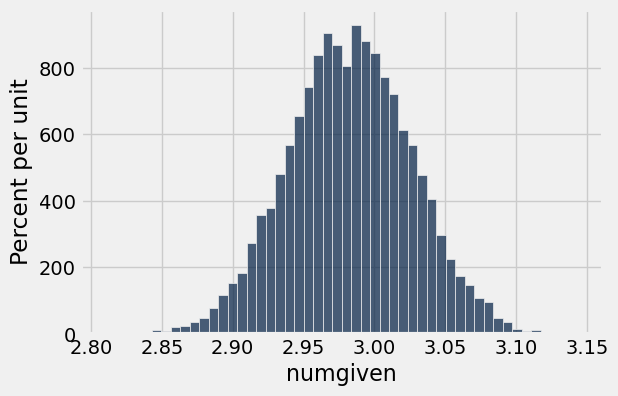

In [118]:
resampled_net_size.hist('numgiven', bins=50)

Let's also check the mean of all values of `numgiven` in our GSS 1985 data:

In [119]:
np.mean(gss_1985_responded['numgiven'])

2.9830176355323319

We can see that the sample means we obtained from 10000 resamples varies around the population mean, and the distribution approximates a normal distribution. 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [120]:
grader.check_all()

q1 results: All test cases passed!

q10 results: All test cases passed!

q12 results: All test cases passed!

q13 results: All test cases passed!

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q5 results: All test cases passed!

q6 results: All test cases passed!

q7 results: All test cases passed!

q9 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [121]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!

    q6 results: All test cases passed!

    q7 results: All test cases passed!

    q9 results: All test cases passed!

    q10 results: All test cases passed!

    q12 results: All test cases passed!

    q13 results: All test cases passed!
